In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time
import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

import torchvision
from torchvision.datasets import MNIST

In [2]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [3]:
# /content/drive/MyDrive/UMDCP/CMSC/CMSC472/JohnOliver1-cropped-face-crop
class AEDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
      
        temp = []
        count = 0
        for filename in os.listdir(file_path):
            if filename.endswith(".jpg"):
                img = cv2.imread(file_path + '/'+filename)
                img = cv2.resize(img,(128,128))

                # grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)

                temp.append(img)

                if count % 100 == 0: print(str(count) + ' images done')

                count += 1
        print(len(temp))
        self.x = torch.tensor(temp,dtype=torch.float32)
        print(self.x[0].shape)
        self.x = torch.flatten(self.x,1)
        print(self.x.shape)
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        ## return image, and, if not test mode, the label at the given index
        ## valid formats include:
        ## {'image': image, 'label': label}
        ## image, label
        ## where image and label have both been converted to torch.Tensors
        image = self.x[idx].clone().detach()
        return image


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# hyperparameters
epochs = 500
learning_rate = 0.001
batch_size = 50

In [29]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=128*128*3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [42]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JohnOliver1-cropped-face-crop')
# train_dataset = MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )
# /content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF
test_dataset = AEDataset('/content/drive/MyDrive/UMDCP/CMSC/CMSC472/JimmyF')
# test_dataset = MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )
print(len(train_dataset))
train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4
)
print(type(train_dataset.__getitem__(0)))

0 images done
100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done
1568
torch.Size([128, 128, 3])
torch.Size([1568, 49152])
0 images done
1
torch.Size([128, 128, 3])
torch.Size([1, 49152])
1568
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:
training_len = len(train_loader)
for epoch in range(epochs):
    loss = 0
    for idx, batch_features in enumerate(train_loader):
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        # batch_features = batch_features.view(-1, 163840).to(device)
        batch_features = batch_features.cuda()
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumultrain_loaderated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / training_len
    
    if(epoch % 20 ==0): print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
print("final loss = " + str(loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1/500, loss = 20046.983765
epoch : 21/500, loss = 7357.476028
epoch : 41/500, loss = 5648.621628
epoch : 61/500, loss = 4552.231354
epoch : 81/500, loss = 3287.815109
epoch : 101/500, loss = 2374.363731
epoch : 121/500, loss = 1904.299370
epoch : 141/500, loss = 1657.032837
epoch : 161/500, loss = 1447.059906
epoch : 181/500, loss = 1324.303482
epoch : 201/500, loss = 1170.007587
epoch : 221/500, loss = 1072.860924
epoch : 241/500, loss = 1003.324112
epoch : 261/500, loss = 942.453596
epoch : 281/500, loss = 885.923683
epoch : 301/500, loss = 860.113819
epoch : 321/500, loss = 822.226593
epoch : 341/500, loss = 785.120041
epoch : 361/500, loss = 769.228363
epoch : 381/500, loss = 790.332855
epoch : 401/500, loss = 736.644064
epoch : 421/500, loss = 714.931082
epoch : 441/500, loss = 701.027155
epoch : 461/500, loss = 682.887840
epoch : 481/500, loss = 662.118351
final loss = 655.730791091919


In [43]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features.cuda()
        test_examples = batch_features.view(-1, 128*128*3).cuda()
        reconstruction = model(batch_features).cpu()
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


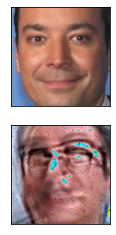

In [44]:
with torch.no_grad():
    number = 1
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow((test_examples[index].cpu().detach().numpy().reshape(128, 128, 3)).astype(np.uint8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(((reconstruction[index].numpy().reshape(128, 128, 3))).astype(np.uint8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()